Accuracy: 0.6820


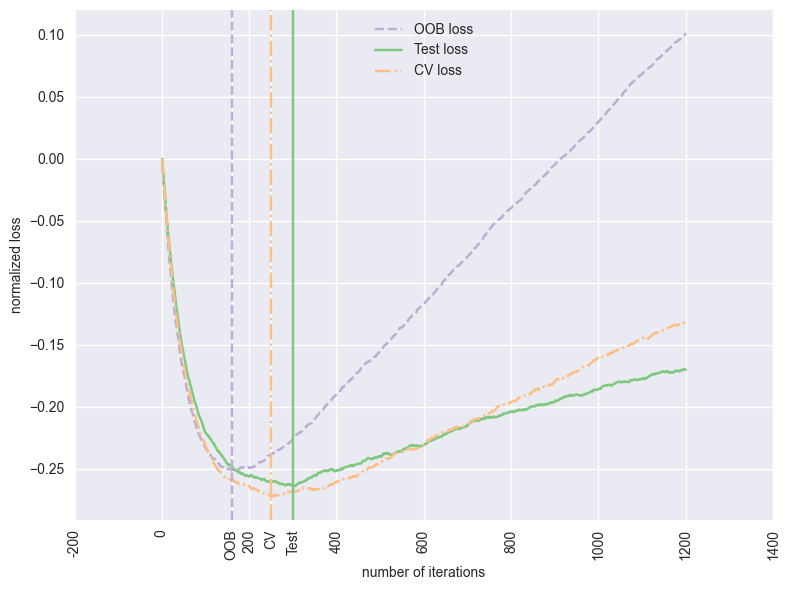

In [1]:
# 导入操作系统库
import os
# 更改工作目录
os.chdir(r"D:\softwares\applied statistics\pythoncodelearning\chap6\sourcecode")
# 导入基础计算库
import numpy as np
# 导入绘图库
import matplotlib.pyplot as plt
# 导入K折交叉验证
from sklearn.model_selection import KFold
# 导入梯度提升分类器
from sklearn.ensemble import GradientBoostingClassifier
# 导入数据集划分工具
from sklearn.model_selection import train_test_split
# 导入log_loss函数
from sklearn.metrics import log_loss
# 导入expit函数
from scipy.special import expit
# 导入绘图库中的字体管理包
from matplotlib import font_manager
# 实现中文字符正常显示
font = font_manager.FontProperties(fname=r"C:\Windows\Fonts\SimKai.ttf")
# 使用seaborn风格绘图
plt.style.use("seaborn-v0_8")
# 样本量
n_samples = 1000
np.random.seed(13)
# 生成x
x1 = np.random.uniform(size=n_samples)
x2 = np.random.uniform(size=n_samples)
x3 = np.random.randint(0, 4, size=n_samples)
# 计算概率
p = expit(np.sin(3 * x1) - 4 * x2 + x3)
# 生成y
y = np.random.binomial(1, p, size=n_samples)
# 合并
X = np.c_[x1, x2, x3]
X = X.astype(np.float32)
# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=9
)
# Fit classifier with out-of-bag estimates
params = {
    "n_estimators": 1200,
    "max_depth": 3,
    "subsample": 0.5,
    "learning_rate": 0.01,
    "min_samples_leaf": 1,
    "random_state": 3,
}
# 构造模型
clf = GradientBoostingClassifier(**params)
# 模型拟合
clf.fit(X_train, y_train)
# 分类准确率
acc = clf.score(X_test, y_test)
print("Accuracy: {:.4f}".format(acc))
# 估计器的数量
n_estimators = params["n_estimators"]
x = np.arange(n_estimators) + 1
def heldout_score(clf, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``."""
    score = np.zeros((n_estimators,), dtype=np.float64)
    # 阶段性预测概率
    for i, y_proba in enumerate(clf.staged_predict_proba(X_test)):
        score[i] = 2 * log_loss(y_test, y_proba[:, 1])
    return score
# CV估计
def cv_estimate(n_splits=None):
    # k折
    cv = KFold(n_splits=n_splits)
    # 构建模型
    cv_clf = GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(X_train, y_train):
        # 每一折下进行模型拟合
        cv_clf.fit(X_train[train], y_train[train])
        # 得分
        val_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    val_scores /= n_splits
    return val_scores

# Estimate best n_estimator using cross-validation
cv_score = cv_estimate(3)
# Compute best n_estimator for test data
test_score = heldout_score(clf, X_test, y_test)
# negative cumulative sum of oob improvements
cumsum = -np.cumsum(clf.oob_improvement_)
# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]
# min loss according to test (normalize such that first loss is 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]
# min loss according to cv (normalize such that first loss is 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]
# 设置曲线的颜色
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))
# 设置线型
oob_line = "dashed"
test_line = "solid"
cv_line = "dashdot"
# plot curves and vertical lines for best iterations
fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
ax.plot(
    x, cumsum, label="OOB loss", 
    color=oob_color, linestyle=oob_line
)
ax.plot(
    x, test_score, label="Test loss", 
    color=test_color, linestyle=test_line
)
ax.plot(
    x, cv_score, label="CV loss", 
    color=cv_color, linestyle=cv_line
)
ax.axvline(x=oob_best_iter, color=oob_color, linestyle=oob_line)
ax.axvline(x=test_best_iter, color=test_color, linestyle=test_line)
ax.axvline(x=cv_best_iter, color=cv_color, linestyle=cv_line)
# add three vertical lines to xticks
xticks = plt.xticks()
xticks_pos = np.array(
    xticks[0].tolist() + [oob_best_iter, cv_best_iter, test_best_iter]
)
xticks_label = np.array(list(
    map(lambda t: int(t), xticks[0])
    ) + ["OOB", "CV", "Test"]
)
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label, rotation=90)
ax.legend(loc="upper center")
ax.set_ylabel("normalized loss")
ax.set_xlabel("number of iterations")
plt.show()
fig.savefig("../codeimage/code4.pdf")
